
<a href="https://colab.research.google.com/github/SMTorg/smt/blob/master/tutorial/SMT_MFK_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div class="jumbotron text-left"><b>
This tutorial describes how to use the SMT toolbox with multifidelity data to build a surrogate model 
SMT which is a python toolbox for building a surrogate model.</b></div>

Mostafa Meliani ISAE-SUPAERO student

Nathalie BARTOLI ONERA/DTIS/M2CI - May 2024
`version SMT 2.5.1 and above`

<p class="alert alert-success" style="padding:1em">
To use SMT models, please follow this link : https://github.com/SMTorg/SMT/blob/master/README.md. 
    The doc is available here: http://smt.readthedocs.io/en/latest/
</p>


For the multifidelity extension, a description of the algorithm is available here https://arc.aiaa.org/doi/pdf/10.2514/6.2019-3236

In [1]:
!pip install smt




# Multi-Fidelity Kriging 

We are interested in learning a high-fidelity function while using low-fidelity information sources to enhance the model, for that we use Le Gratiet recursive formulation of multi-fidelity Kriging.

<p class="alert alert-warning" style="padding:1em">
An important assumption by using this recursive formulation is the nested DOE. 
If we have thow fidelity levels (HF and LF)
$$X_{HF} \subset X_{LF}$$
 </p>   

### Kennedy O'Hagan/Le Gratiet recursive formulation:
To perform Le Gratiet's learning, we first learn the lowest fidelity, then we consecutively learn the relationship between every two consecutive fidelity levels (scaling factor $\rho_{k-1}$ and discrepancy function $\delta_k(\cdot)$).

$$\mu_{k} = \rho_{k-1}\;\mu_{k-1} + \mu_{\delta_k}\\
\sigma^2_{k} = \rho_{k-1}^2\;\sigma^2_{k-1}+\sigma^2_{\delta_k}$$

![Multi-Fidelity 1-D toy problem](co-krigeage.png)

This generally results in a better surrogate model compared to training the high-fidelity alone.

### SMT 
SMT is a joint library between NASA, UoM, ONERA and ISAE-SUPAERO. It offers many surrogate modeling tools with a focus on derivatives. Le Gratiet's formulation was implemented as part of SMT.

After dowmloading and installing SMT library from: https://github.com/SMTorg/smt

We import the needed packages

In [2]:
from smt.applications import MFK
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## 1- Build a multifidelity model using two fidelity levels

In [3]:
#defining low and high fidelity functions
def LF_function(x):
    return 0.5*((x*6-2)**2)*np.sin((x*6-2)*2)+(x-0.5)*10. - 5

def HF_function(x):
    return ((x*6-2)**2)*np.sin((x*6-2)*2)

Text(0, 0.5, '$y$')

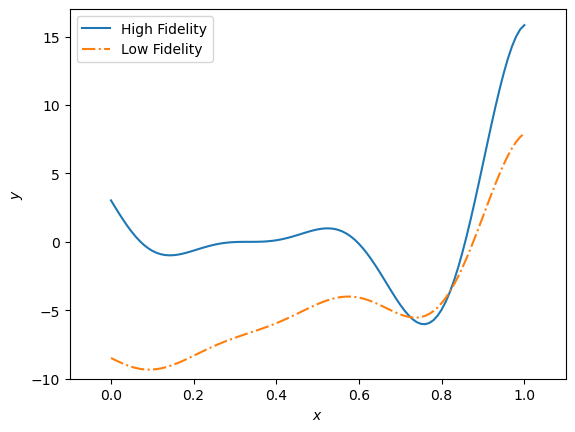

In [4]:
# Ploting High and low fidelity functions

x = np.linspace(0, 1, 101, endpoint = True).reshape(-1,1)
plt.figure()

plt.plot(x, HF_function(x), label ='High Fidelity')
plt.plot(x, LF_function(x), linestyle = '-.' , label ='Low Fidelity')

plt.legend(loc=0)
plt.ylim(-10,17)
plt.xlim(-0.1,1.1)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')


#### Sampling
The idea when building a mutli-fidelity design of experiment is to cover as much space as possible with low-fidelity data and use enough high fidelity samples to learn the relationship between fidelity-levels.

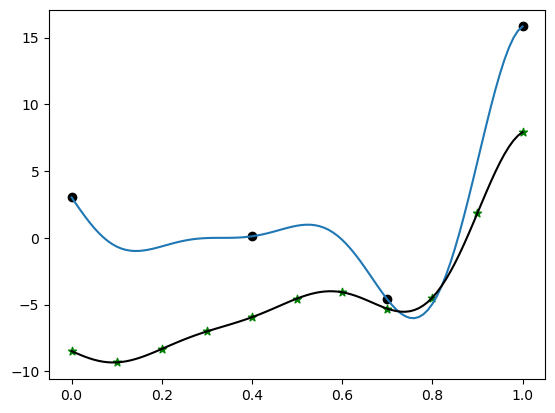

In [5]:
#Linear sampling
ndim=1

Xt_c = np.linspace(0, 1, 11, endpoint=True).reshape(-1, ndim)
#To have nested DOE
Xt_e = np.array([0.0,0.4, 0.7, 1.0]).reshape(-1, ndim)


# Evaluate the HF and LF functions
yt_e = HF_function(Xt_e)
yt_c = LF_function(Xt_c)

plt.plot(x, HF_function(x), label ='High Fidelity')
plt.plot(x, LF_function(x) , c ='k', label ='Low Fidelity')
plt.scatter(Xt_e, yt_e, marker = 'o' , color ='k', label ='HF doe')
plt.scatter(Xt_c, yt_c, marker = '*' , color ='g', label ='LF doe')


Building a SMT object has many options, you can check all the options in the doc website: http://smt.readthedocs.io

In [6]:
# build the MFK object 
sm = MFK(theta0=Xt_e.shape[1] * [1.0])

# low-fidelity dataset names being integers from 0 to level -1
sm.set_training_values(Xt_c, yt_c, name = 0) 
# high-fidelity dataset without name
sm.set_training_values(Xt_e, yt_e) 

# train the model
sm.train()

# test training
x = np.linspace(0, 1, 101, endpoint = True).reshape(-1,1)

# query the outputs
y = sm.predict_values(x)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.3339033
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0010445
   
   Prediction time/pt. (sec) :  0.0000103
   


D:\bartoli\Documents\Dev_Python38_39\smt\smt\surrogate_models\krg_based.py:968: UserWarning: R is too ill conditioned. Poor combination of regression model and observations.
  warnings.warn(


Text(0, 0.5, '$y$')

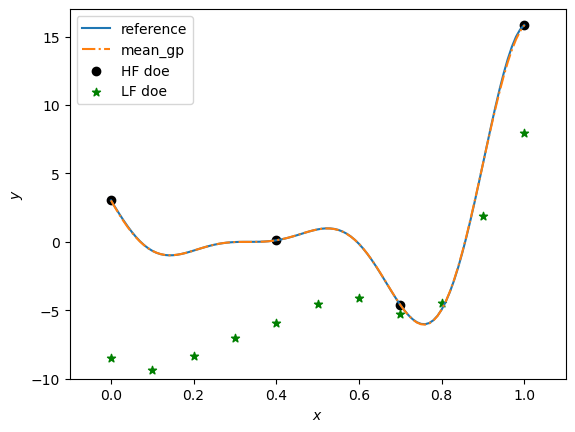

In [7]:
# plot the outputs 
plt.plot(x, HF_function(x), label ='reference')
plt.plot(x, y, linestyle = '-.' , label ='mean_gp')
plt.scatter(Xt_e, yt_e, marker = 'o' , color ='k', label ='HF doe')
plt.scatter(Xt_c, yt_c, marker = '*' , color ='g', label ='LF doe')

plt.legend(loc=0)
plt.ylim(-10,17)
plt.xlim(-0.1,1.1)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

In [8]:
# Accessing the variance and derivative of the model
MSE = sm.predict_variances(x)
der = sm.predict_derivatives(x, kx=0)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0015521
   
   Prediction time/pt. (sec) :  0.0000154
   


Text(0, 0.5, '$y$')

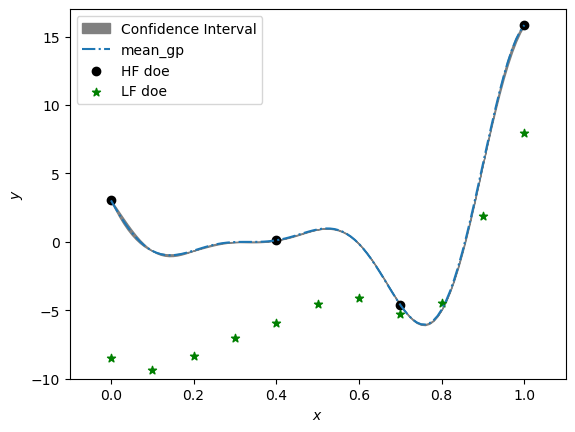

In [9]:
# plot the variance 
plt.fill_between(np.ravel(x), np.ravel(y-2*np.sqrt(MSE)), np.ravel(y+2*np.sqrt(MSE)),color='grey' ,label ='Confidence Interval')
plt.plot(x, y, linestyle = '-.' , label ='mean_gp')
plt.scatter(Xt_e, yt_e, marker = 'o' , color ='k', label ='HF doe')
plt.scatter(Xt_c, yt_c, marker = '*' , color ='g', label ='LF doe')

plt.legend(loc=0)
plt.ylim(-10,17)
plt.xlim(-0.1,1.1)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

<div class="alert alert-danger" >
<p> In most of the surrogate models $y\in\mathbb{R}$, so if you have multiple outputs $y\in\mathbb{R}^d$ (which are considered as independant outputs), add an external loop to build one surrogate model per output. The correlations betweens outputs are not taken into account. 
</div>